In [29]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import cumtrapz
import scipy.constants as const
import pandas as pd
import matplotlib.pyplot as plt
import uncertainties as unc
%matplotlib inline

def secondDerivative(x,y):
    deri = np.ones(len(x)-2)
    for i in range(len(deri)):
        deri[i] = (y[i+2] - 2*y[i+1] + y[i]) / (x[i+2] - x[i])**2
    return deri

def restGlied(x,y):
    return (max(x)-min(x))**3/(len(x)**2) / 24 * max(secondDerivative(x, y))

    
def durchlasskurve(nu, nu0, Q, Ue2):
    return Ue2/Q**2 * 1/((nu/nu0)**2 + (nu/nu0)**-2 + Q**-2 -2)
def gerade(x, m, b):
    return m*x+b

def deltaNu(nu, R):
    if 10 <= nu < 100:
        return 0.15*nu - 0.3
    if 100 <= nu < 10e3:
        return 0.14*nu + 0.7
    if 10e3 <= nu < 50e3:
        return 0.135*nu + 0.05e3
    if 50e3 <= nu <= 100e3:
        if R == 2200:
            return 0.115*nu + 1.05e3
        elif R == 4680:
            return 0.109*nu + 1.2e3
        else:
            print('Falscher Widerstand')
            return -1
    else:
        print('Out of Range. Nu:{}'.format(nu))
        return -1

def W(U, nu, R):
    return U**2/(deltaNu(nu, R)*R**2)


### Sinus Normal

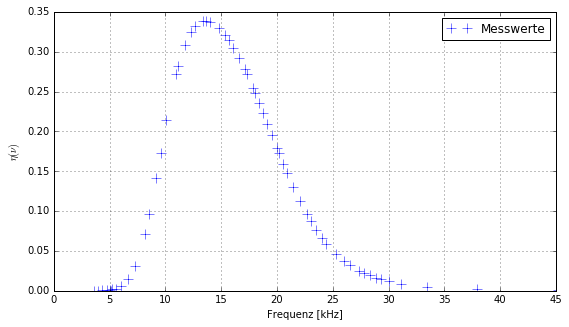

In [2]:
sin1 = pd.read_csv('daten_sin.csv', header=0, delimiter='\t', names=['frequenz', 'voltage','vN'])
sin1 = sin1.fillna(method='pad')

# Rauschen der Aparatur abziehen
eigenRauschen = pd.read_csv('eigenRauschen1.csv', header=0, delimiter='\t', index_col=0, names=['eigenRauschen'])
sin1 = sin1.join(eigenRauschen, on='vN', how='left')
sin1['voltage'] -= sin1['eigenRauschen']

#Einheiten Umrechnen

sin1['frequenzkHz'] = sin1.frequenz #Plot soll in kHz bleiben
sin1.frequenz *= 1000 # in Herz umrechnen
sin1.index = sin1.frequenz
sin1['voltage'] /= 1000 #in Volt umrechnen

# Verstärkungen aufzählen
V_in = 175e-3 #Eingangsspannung
V_ab = 1000 #Abschwächer
V_V = 1000 #Vorverstärkung
V_N = sin1.vN #Nachverstärker
V_gl = 10 #Gleichspannungsverstärker

sin1['voltageCorrected'] = sin1.voltage / (V_in/V_ab)**2 / (V_gl * V_N**2 * V_V**2)
sin1['verstaerkung'] = V_gl * V_V**2 * V_N



# Plot der Messewerte
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
ax.plot(sin1.frequenzkHz, sin1.voltageCorrected, linestyle='', marker='+', markersize=10, label='Messwerte')
ax.set_xlim((0,45))
ax.set_xlabel('Frequenz [kHz]')
ax.set_ylabel(r'$\eta(\nu)$')
ax.grid()
ax.legend(loc='best')
fig.savefig('results/sin.pdf')

# Latex Tabelle
output = sin1.sort_values('frequenz')
output.voltageCorrected *= 1000
output.to_latex('results/latex_sinus1.tab', header=False, index=False,
            float_format='%2.2f', columns=['frequenz','vN','voltageCorrected'],)

plt.show()

### Sinus Korrel

15021.62 \pm 18.02
8.09 \pm 0.26
\left(2.43 \pm 0.04\right) \times 10^{-1}


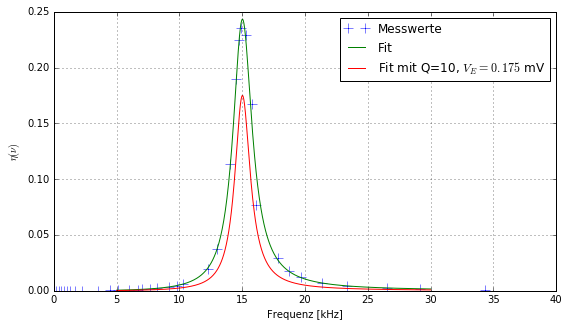

In [3]:
sin2 = pd.read_csv('daten_korrel_sin.csv', header=0, delimiter='\t', names=['frequenz', 'voltage','vN'])
sin2 = sin2.fillna(method='pad')

# Rauschen der Aparatur abziehen (Korrelationsaufbau)
eigenRauschen = pd.read_csv('eigenRauschen2.csv', header=0, delimiter='\t', index_col=0, names=['eigenRauschen'])
sin2 = sin2.join(eigenRauschen, on='vN', how='left')
sin2['voltage'] -= sin2['eigenRauschen']

#Einheiten Umrechnen
sin2['frequenzkHz'] = sin2.frequenz # Plot soll in kHz bleiben
sin2.frequenz *= 1000. # in Herz umrechnen
sin2.index = sin2.frequenz 
sin2['voltage'] /= 1000. #in Volt umrechnen



# Verstärkungen aufzählen
V_in = 175e-3 #Eingangsspannung
V_ab = 1000 #Abschwächer
V_V = 1000 #Vorverstärkung
V_N = sin2.vN *10 #Nachverstärker
V_gl = 10 #Gleichspannungsverstärker

sin2['voltageCorrected'] = sin2.voltage / (V_in/V_ab)**2 / V_gl / V_N**2 / V_V**2

# Fit und Plot
popt, pcov = curve_fit(durchlasskurve, sin2.frequenz, sin2.voltageCorrected, p0=[1e4,8,175e-3])
perr = np.sqrt(np.diag(pcov))

nu_0 = unc.ufloat(popt[0], perr[0])
Q = unc.ufloat(popt[1], perr[1])
U = unc.ufloat(popt[2], perr[2])

with open("results/sin2_nu0.fit", "w") as text_file:
    print('{:.2fL}'.format(nu_0), file=text_file)
    print('{:.2fL}'.format(nu_0))
with open("results/sin2_Q.fit", "w") as text_file:
    print('{:.2fL}'.format(Q), file=text_file)
    print('{:.2fL}'.format(Q))
with open("results/sin2_U.fit", "w") as text_file:
    print('{:.2eL}'.format(U), file=text_file)
    print('{:.2eL}'.format(U))
    
    
x = np.linspace(5e3, 30e3, 1000)

# Plot der Messewerte
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
ax.plot(sin2.frequenzkHz, sin2.voltageCorrected, linestyle='', marker='+', markersize=10, label='Messwerte')

y = durchlasskurve(x, popt[0], popt[1], popt[2])
ax.plot(x/1000,y, label='Fit')

y2 = durchlasskurve(x, popt[0], 10, 175e-3)
ax.plot(x/1000,y2, label='Fit mit Q=10, $V_E=0.175$ mV')

ax.set_xlim((0,40))
ax.set_xlabel('Frequenz [kHz]')
ax.set_ylabel(r'$\eta(\nu)$')
ax.grid()
ax.legend(loc='upper right')
fig.savefig('results/sin_korrel.pdf')

plt.show()

### Calc Delta Nu

In [4]:
dNu1 = np.trapz(y=sin1.voltageCorrected.values, x=sin1.frequenz)
rG1 = restGlied(sin1.frequenz.values, sin1.voltageCorrected.values)
deltaNu1 = unc.ufloat(dNu1, rG1)

dNu2 = np.trapz(y=sin2.voltageCorrected.values, x=sin2.frequenz)
rG2 = restGlied(sin2.frequenz.values, sin2.voltageCorrected.values)
deltaNu2_file = unc.ufloat(dNu2, rG2)
deltaNu2 = unc.ufloat(dNu2, 0) #Error was too big, so we set it to 0 for further analysis

with open("results/sin1_DeltaNu.fit", "w") as text_file:
    print('{:.2fL}'.format(deltaNu1), file=text_file)
    print('{:.2fL}'.format(deltaNu1))

with open("results/sin2_DeltaNu.fit", "w") as text_file:
    print('{:.2fL}'.format(deltaNu2_file), file=text_file)
    print('{:.2fL}'.format(deltaNu2_file))



3870.62 \pm 25.27
696.26 \pm 8807374.54


### Rauschzahl

In [5]:
U500 = unc.ufloat(706e-3, 0.02*706e-3)
F500 = U500 / (4*const.Boltzmann * 293 * 500 * deltaNu1 * 10**13)
with open("results/rausch1.fit", "w") as text_file:
    print('{:L}'.format(U500), file=text_file)
    print('F500_1={:L}'.format(U500))

U500_2 = unc.ufloat(625e-3, 0.02*625e-3)
F500_2 = U500 / (4*const.Boltzmann * 293 * 500 * deltaNu2 * 10**15)
with open("results/rausch2.fit", "w") as text_file:
    print('{:L}'.format(U500_2), file=text_file)
    print('F500_2={:L}'.format(U500_2))

F500_1=0.706 \pm 0.014
F500_2=0.625 \pm 0.013


### Widerstand 1 normal

m=\left(1.20 \pm 0.01\right) \times 10^{-16}
b=\left(2.92 \pm 0.45\right) \times 10^{-15}
kB=\left(2.64 \pm 0.02\right) \times 10^{-23}


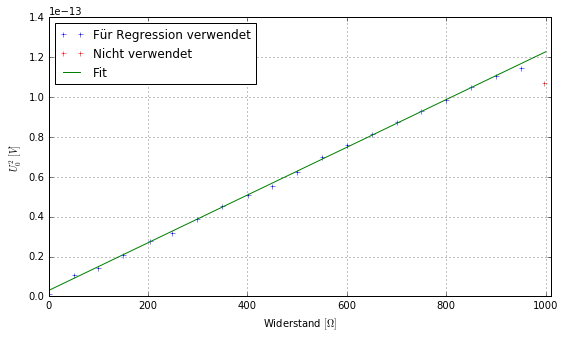

In [6]:
daten = pd.read_csv('daten_wid1.csv', header=0, delimiter='\t', names=['widerstand', 'voltage','vN'])


daten = daten.fillna(method='pad')
daten.index = daten.widerstand
daten.voltage /= 1000 #in Volt umrechnen

# Verstärkungen aufzählen
V_V = 1000 #Vorverstärkung
V_N = daten.vN #Nachverstärker
V_gl = 10 #Gleichspannungsverstärker

daten['voltageNormed'] = daten.voltage / (V_gl * V_N**2 * V_V**2)


noFit = daten.query('widerstand > 960')
daten = daten.query('widerstand <= 960')

# Fit
popt, pcov = curve_fit(gerade, daten.widerstand, daten.voltageNormed)
perr = np.sqrt(np.diag(pcov))

x = np.linspace(0, 1000, 20)
y = gerade(x,popt[0], popt[1])
m = unc.ufloat(popt[0], perr[0])
b = unc.ufloat(popt[1], perr[1])
kB1 = m/(4 * deltaNu1 * 293.15)

with open("results/wid1_m.fit", "w") as text_file:
    print('{:.3L}'.format(m), file=text_file)
    print('m={:.3L}'.format(m))
with open("results/wid1_b.fit", "w") as text_file:
    print('{:.3L}'.format(b), file=text_file)
    print('b={:.3L}'.format(b))
with open("results/wid1_kb.fit", "w") as text_file:
    print('{:.3L}'.format(kB1), file=text_file)
    print('kB={:.3L}'.format(kB1))


fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
daten.voltageNormed.plot(ax=ax, linestyle='', marker='+', color='blue', markersize=5, label='Für Regression verwendet')
noFit.voltageNormed.plot(ax=ax, linestyle='', marker='+', color='red', markersize=5, label='Nicht verwendet')
ax.plot(x,y, label='Fit', color='green')
ax.set_xlim((0,1010))
ax.set_xlabel('Widerstand $[\Omega]$')
ax.set_ylabel('$U_0^2\ [V]$')
ax.grid()
ax.legend(loc='best')
fig.savefig('results/wid1.pdf')
plt.show()

### Widerstand 2 normal

m=\left(1.01 \pm 0.01\right) \times 10^{-13}
b=\left(-3.75 \pm 1.58\right) \times 10^{-14}
kB=\left(2.23 \pm 0.02\right) \times 10^{-20}


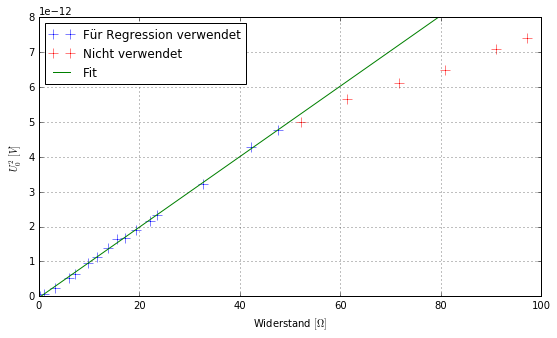

In [7]:
daten = pd.read_csv('daten_wid2.csv', header=0, delimiter='\t', names=['widerstand', 'voltage','vN'])

daten = daten.fillna(method='pad')
daten.index = daten.widerstand
daten.voltage /= 1000 #in Volt umrechnen

# Verstärkungen aufzählen
V_V = 1000 #Vorverstärkung
V_N = daten.vN #Nachverstärker
V_gl = 10 #Gleichspannungsverstärker

daten['voltageNormed'] = daten.voltage / (V_gl * V_N**2 * V_V**2)


noFit = daten.query('widerstand > 50')
daten = daten.query('widerstand <= 50')

# Fit
popt, pcov = curve_fit(gerade, daten.widerstand, daten.voltageNormed)
perr = np.sqrt(np.diag(pcov))

x = np.linspace(0, 100, 20)
y = gerade(x,popt[0], popt[1])
m = unc.ufloat(popt[0], perr[0])
b = unc.ufloat(popt[1], perr[1])
kB2 = m/(4 * deltaNu1 * 293.15)

with open("results/wid2_m.fit", "w") as text_file:
    print('{:.3L}'.format(m), file=text_file)
    print('m={:.3L}'.format(m))
with open("results/wid2_b.fit", "w") as text_file:
    print('{:.3L}'.format(b), file=text_file)
    print('b={:.3L}'.format(b))
with open("results/wid2_kb.fit", "w") as text_file:
    print('{:.3L}'.format(kB2), file=text_file)
    print('kB={:.3L}'.format(kB2))

fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111)
daten.voltageNormed.plot(ax=ax, linestyle='', marker='+', color='blue', markersize=10, label='Für Regression verwendet')
noFit.voltageNormed.plot(ax=ax, linestyle='', marker='+', color='red', markersize=10, label='Nicht verwendet')




ax.plot(x,y, label='Fit', color='green')
ax.set_xlim((0,100))
ax.set_ylim((0,0.8e-11))
ax.set_xlabel('Widerstand $[\Omega]$')
ax.set_ylabel('$U_0^2\ [V]$')
ax.grid()
ax.legend(loc='best')
fig.savefig('results/wid2.pdf')
plt.show()

### Widerstand 1 Korrel

m=\left(3.11 \pm 0.01\right) \times 10^{-17}
b=\left(-6.43 \pm 5.35\right) \times 10^{-17}
kB=\left(3.81 \pm 0.01\right) \times 10^{-23}


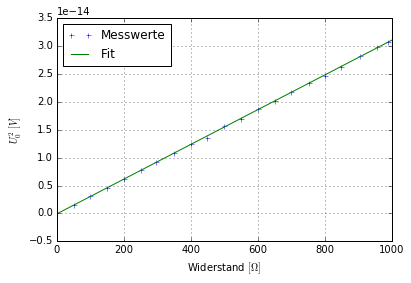

In [8]:
daten = pd.read_csv('daten_korrel_wid1.csv', header=0, delimiter='\t', names=['widerstand', 'voltage','vN'])
daten = daten.fillna(method='pad')
daten.index = daten.widerstand
daten.voltage /= 1000 #in Volt umrechnen

# Verstärkungen aufzählen
V_V = 1000 #Vorverstärkung
V_S = 10   #Selektive Verstärkung
V_N = daten.vN #Nachverstärker
V_gl = 10 #Gleichspannungsverstärker

daten['voltageNormed'] = daten.voltage / (V_gl * V_S**2 * V_N**2 * V_V**2)


# Fit
popt, pcov = curve_fit(gerade, daten.widerstand, daten.voltageNormed)
perr = np.sqrt(np.diag(pcov))
m = unc.ufloat(popt[0], perr[0])
b = unc.ufloat(popt[1], perr[1])
kB1_korrel = m/(4 * deltaNu2 * 293.15)

with open("results/wid1_korrel_m.fit", "w") as text_file:
    print('{:.3L}'.format(m), file=text_file)
    print('m={:.3L}'.format(m))
with open("results/wid1_korrel_b.fit", "w") as text_file:
    print('{:.3L}'.format(b), file=text_file)
    print('b={:.3L}'.format(b))
with open("results/wid1_korrel_kb.fit", "w") as text_file:
    print('{:.3L}'.format(kB1_korrel), file=text_file)
    print('kB={:.3L}'.format(kB1_korrel))

x = np.linspace(0, 1000, 20)
y = gerade(x,popt[0], popt[1])


daten.voltageNormed.plot(linestyle='', marker='+', markersize=5, label='Messwerte')
plt.plot(x,y, label='Fit')
plt.xlim((0,1000))
plt.xlabel('Widerstand $[\Omega]$')
plt.ylabel('$U_0^2\ [V]$')
plt.grid()
plt.legend(loc='best')
plt.savefig('results/wid1_korrel.pdf')
plt.show()

### Widerstand 2 Korrel

m=\left(2.81 \pm 0.02\right) \times 10^{-14}
b=\left(1.62 \pm 2.08\right) \times 10^{-15}
kB=\left(3.44 \pm 0.03\right) \times 10^{-20}


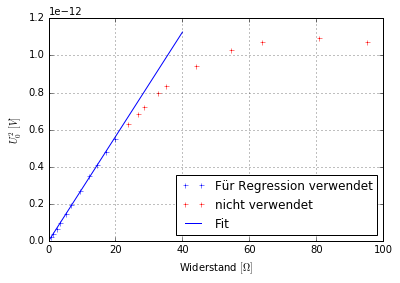

In [9]:
daten = pd.read_csv('daten_korrel_wid2.csv', header=0, delimiter='\t', names=['widerstand', 'voltage','vN'])
daten = daten.fillna(method='pad')
daten.index = daten.widerstand
daten.voltage /= 1000 #in Volt umrechnen

# Verstärkungen aufzählen
V_V = 1000 #Vorverstärkung
V_S = 10   #Selektive Verstärkung
V_N = daten.vN #Nachverstärker
V_gl = 10 #Gleichspannungsverstärker

daten['voltageNormed'] = daten.voltage / (V_gl * V_S**2 * V_N**2 * V_V**2)


fit = daten.query('widerstand <= 20')
noFit = daten.query('widerstand > 20')

# Fit
popt, pcov = curve_fit(gerade, fit.widerstand, fit.voltageNormed)
perr = np.sqrt(np.diag(pcov))
m = unc.ufloat(popt[0], perr[0])
b = unc.ufloat(popt[1], perr[1])
kB2_korrel = m/(4 * deltaNu2 * 293.15)

with open("results/wid2_korrel_m.fit", "w") as text_file:
    print('{:.3L}'.format(m), file=text_file)
    print('m={:.3L}'.format(m))
with open("results/wid2_korrel_b.fit", "w") as text_file:
    print('{:.3L}'.format(b), file=text_file)
    print('b={:.3L}'.format(b))
with open("results/wid2_korrel_kb.fit", "w") as text_file:
    print('{:.3L}'.format(kB2_korrel), file=text_file)
    print('kB={:.3L}'.format(kB2_korrel))

x = np.linspace(0, 40, 20)
y = gerade(x,popt[0], popt[1])
    
fit.voltageNormed.plot(linestyle='', marker='+', markersize=5, color = 'blue', label='Für Regression verwendet')
noFit.voltageNormed.plot(linestyle='', marker='+', markersize=5, color='red', label='nicht verwendet')
plt.plot(x,y, label='Fit')

plt.xlim((0,100))
plt.xlabel('Widerstand $[\Omega]$')
plt.ylabel('$U_0^2\ [V]$')
plt.grid()
plt.legend(loc='best')
plt.savefig('results/wid2_korrel.pdf')
plt.show()

# Glühkathoden

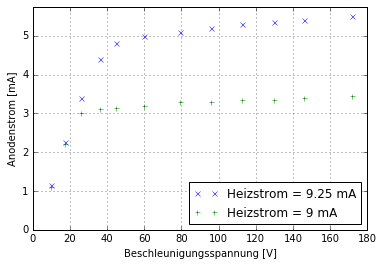

In [10]:
daten = pd.read_csv('reinMet_Sat9.csv', header=0, delimiter='\t', names=['frequenz', '9'])
daten2 = pd.read_csv('reinMet_Sat925.csv', header=0, delimiter='\t', names=['frequenz', 'voltage'])
daten['925'] = daten2['voltage']
daten.index = daten.frequenz

daten['925'].plot(linestyle='', marker='x', markersize=5, label="Heizstrom = 9.25 mA")
daten['9'].plot(linestyle='', marker='+', markersize=5, label="Heizstrom = 9 mA")
plt.xlim((0,180))
plt.ylim((0,5.75))
plt.xlabel('Beschleunigungsspannung [V]')
plt.ylabel('Anodenstrom [mA]')
plt.grid()
plt.legend(loc='best')
plt.savefig('results/kathRein_sat.pdf')
plt.show()

### Oxidkathode

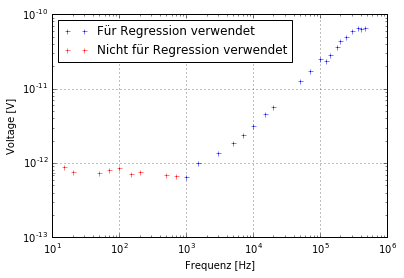

In [91]:
daten = pd.read_csv('oxidKath_K.csv', header=0, delimiter='\t', names=['frequenz', 'spannung', 'spannung_min', 'spannung_max', 'vN', 'deltaNu'])

# in Hertz und Volt umrechnen
daten.frequenz *= 1000
daten['spannung'] /= 1000
daten['spannung_min'] /= 1000
daten['spannung_max'] /= 1000
daten.index = daten.frequenz

# schätze Fehler durch Standardabweichung ab
err = lambda x : np.sqrt((x.spannung - x.spannung_min)**2 + (x.spannung - x.spannung_max)**2)
daten['spannung_error'] = daten.apply(err, axis=1)


# Verstärkungen aufzählen
V_V = 1000 #Vorverstärkung
V_S = np.ones(len(daten.index))          #Selektive Verstärkung
V_S[daten.frequenz.values <= 1e5] *= 10  #nur bis 100khz, danach keine selektive Verstärkung
V_N = daten.vN #Nachverstärker
V_gl = 10 #Gleichspannungsverstärker

daten['spannungNormed'] = daten.spannung / (V_gl * V_S**2 * V_N**2 * V_V**2)
daten['spannung_error'] = daten.spannung_error / (V_gl * V_S**2 * V_N**2 * V_V**2)

fit = daten.query('frequenz >= 1000')
noFit = daten.query('frequenz < 1000')



fit.spannungNormed.plot(linestyle='', marker='+', markersize=5, color = 'blue', label='Für Regression verwendet')
noFit.spannungNormed.plot(linestyle='', marker='+', markersize=5, color = 'red', label='Nicht für Regression verwendet')
plt.xlim((10,1e6))

plt.xlabel('Frequenz [Hz]')
plt.ylabel('Voltage [V]')
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend(loc='best')
#plt.savefig('results/kathoxid_e0.pdf')

plt.show()

### Reinkathode e0

m=\left(3.09 \pm 0.02\right) \times 10^{-11}
b=\left(-2.88 \pm 0.63\right) \times 10^{-12}
e0=\left(3.30 \pm 0.02\right) \times 10^{-19}


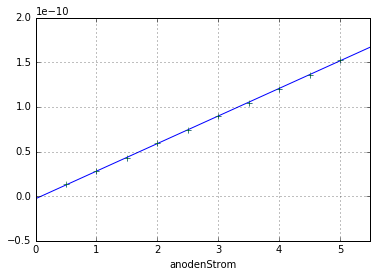

In [131]:
daten = pd.read_csv('reinMet_e0.csv', header=0, delimiter='\t', names=['anodenStrom', 'rauschspannung', 'gain'])
daten = daten.fillna(method='pad')

daten.index = daten.anodenStrom
daten['anodenStrom_A'] = daten.anodenStrom / 1000

V_V = 1000 #Vorverstärkung
V_N = daten.gain #Nachverstärker
V_gl = 10 #Gleichspannungsverstärker

daten['stromNormed'] = daten.rauschspannung / (V_V * V_N * V_gl)**2 / 4680

# Fit
popt, pcov = curve_fit(gerade, daten.anodenStrom, daten.stromNormed, p0=[0,1e-15])
perr = np.sqrt(np.diag(pcov))
m = unc.ufloat(popt[0], perr[0])
b = unc.ufloat(popt[1], perr[1])
e0 = m/2 /10000 / 4680

with open("results/rein_m.fit", "w") as text_file:
    print('{:.3L}'.format(m), file=text_file)
    print('m={:.3L}'.format(m))
with open("results/rein_b.fit", "w") as text_file:
    print('{:.3L}'.format(b), file=text_file)
    print('b={:.3L}'.format(b))
with open("results/rein_e0.fit", "w") as text_file:
    print('{:.3L}'.format(e0), file=text_file)
    print('e0={:.3L}'.format(e0))

x = np.linspace(0, 5.5, 10)
y = gerade(x,popt[0], popt[1])
    
daten.stromNormed.plot(linestyle='', marker='+', markersize=5, color = 'blue', label='Messwerte')
plt.plot(x,y, label='Fit')



daten.head()
daten.stromNormed.plot(marker='+', linestyle='')
plt.grid()
plt.show()

### Reinkathode Rauschspektrum

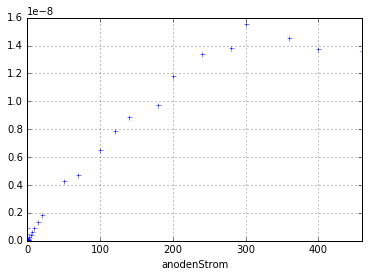

,anodenStrom,spannung,spannung_min,spannung_max,gain,anodenStrom_A,spannungNormed
anodenStrom,,,,,,,
0.010,0.010,940.0,900.0,960.0,10.0,0.000010,9.400000e-10
0.015,0.015,1930.0,1900.0,1990.0,20.0,0.000015,4.825000e-10
0.020,0.020,910.0,900.0,920.0,20.0,0.000020,2.275000e-10
0.030,0.030,480.0,478.0,485.0,20.0,0.000030,1.200000e-10
0.040,0.040,290.0,286.0,294.0,20.0,0.000040,7.250000e-11


In [148]:
daten = pd.read_csv('reinMet_K.csv', header=0, delimiter='\t', names=['anodenStrom', 'spannung', 'spannung_min', 'spannung_max', 'gain'])
daten = daten.fillna(method='pad')

daten.index = daten.anodenStrom
daten['anodenStrom_A'] = daten.anodenStrom / 1000

V_V = 1000 #Vorverstärkung
V_N = daten.gain #Nachverstärker
V_S = np.ones(len(daten.index))          #Selektive Verstärkung
V_S[daten.index.values <= 100] *= 10  #nur bis 100khz, danach keine selektive Verstärkung
V_gl = 10 #Gleichspannungsverstärker

daten['spannungNormed'] = daten.spannung / (V_V * V_N * V_gl*V_S)**2
daten.sort_index(inplace=True)

# Fit
'''
popt, pcov = curve_fit(gerade, daten.anodenStrom, daten.stromNormed, p0=[0,1e-15])
perr = np.sqrt(np.diag(pcov))
m = unc.ufloat(popt[0], perr[0])
b = unc.ufloat(popt[1], perr[1])
e0 = m/2 /10000 / 4680

with open("results/rein_m.fit", "w") as text_file:
    print('{:.3L}'.format(m), file=text_file)
    print('m={:.3L}'.format(m))
with open("results/rein_b.fit", "w") as text_file:
    print('{:.3L}'.format(b), file=text_file)
    print('b={:.3L}'.format(b))
with open("results/rein_e0.fit", "w") as text_file:
    print('{:.3L}'.format(e0), file=text_file)
    print('e0={:.3L}'.format(e0))

x = np.linspace(0, 5.5, 10)
y = gerade(x,popt[0], popt[1])
''' 

daten.spannungNormed.plot(linestyle='', marker='+', markersize=5, color = 'blue', label='Messwerte')
#plt.plot(x,y, label='Fit')




#daten.stromNormed.plot(marker='+', linestyle='')
plt.grid()
plt.show()
daten.head()

Out of Range. Nu:460000.0
Out of Range. Nu:400000.0
Out of Range. Nu:360000.0
Out of Range. Nu:300000.0
Out of Range. Nu:240000.0
Out of Range. Nu:200000.0
Out of Range. Nu:180000.0
Out of Range. Nu:140000.0
Out of Range. Nu:120000.0


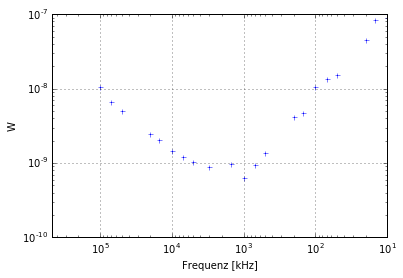

In [13]:
#W(daten.voltageNormed, daten.frequenz, 2200)

daten['W'] = daten.apply(lambda x : W(x.voltageNormed, x.frequenz, 2200), axis=1)
daten.W.plot(linestyle='', marker='+', markersize=5)
#plt.xlim((1e1,1.2e5))
plt.xlabel('Frequenz [kHz]')
plt.ylabel('W')
plt.grid()
plt.loglog()
plt.savefig('results/kathOxid.pdf')
plt.show()

Out of Range. Nu:1063000.0
Out of Range. Nu:452000.0
Out of Range. Nu:338000.0
Out of Range. Nu:222000.0
Out of Range. Nu:605000.0
Out of Range. Nu:428000.0
Out of Range. Nu:250000.0
Out of Range. Nu:550000.0
Out of Range. Nu:360000.0
Out of Range. Nu:248000.0
Out of Range. Nu:1130000.0
Out of Range. Nu:511000.0
Out of Range. Nu:625000.0
Out of Range. Nu:146000.0
Out of Range. Nu:900000.0
Out of Range. Nu:1900000.0
Out of Range. Nu:900000.0
Out of Range. Nu:146000.0
Out of Range. Nu:478000.0
Out of Range. Nu:286000.0
Out of Range. Nu:1960000.0
Out of Range. Nu:354000.0
Out of Range. Nu:387000.0
Out of Range. Nu:472000.0
Out of Range. Nu:551000.0
Out of Range. Nu:533000.0
Out of Range. Nu:621000.0
Out of Range. Nu:580000.0
Out of Range. Nu:548000.0
Out of Range. Nu:543000.0


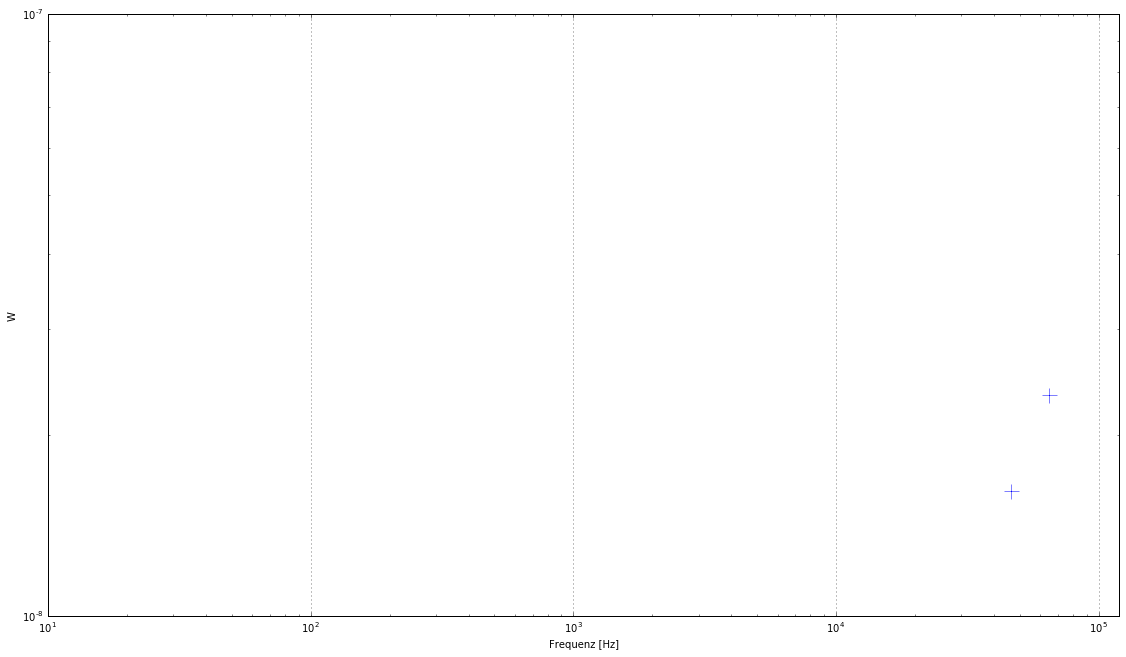

In [14]:
fig = plt.figure(figsize=(19.2,10.8))
daten = pd.read_csv('reinKath_K.csv', header=0, delimiter='\t', names=['frequenz', 'voltage','vN'])
daten = daten.fillna(method='pad')
daten.frequenz = daten.frequenz*1000
daten.index = daten.frequenz
daten['voltageNormed'] = daten.voltage / daten.vN**2

daten['W'] = daten.apply(lambda x : W(x.voltageNormed, x.frequenz, 4680), axis=1)
daten.W.plot(linestyle='', marker='+', markersize=15)
plt.xlim((1e1,1.2e5))
plt.xlabel('Frequenz [Hz]')
plt.ylabel('W')
plt.grid()
plt.loglog()
plt.savefig('results/kathRein.pdf')
plt.show()